In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score

from cleaning import df
sns.set()



Feature Selection (`sklearn.feature_selection`):
- `VarianceThreshold`
- **`SelectKBest`**
- `SelectFromModel`

Hyperparameter Tuning:
- `GridSearchCV`

Learning Models:
- `LogisticRegression`
- `RandomForestClassifier`
- `SVM`
- `KNNeighborsClassifier`


Metrics:
- Precision Score
- Recall Score
- ROC-AUC
- F1 Score

The first model I am going to trye is Logistic Regression. To begin, I need to split my data into test set and training set.

The cell below implements GridSearchCV to optimize a Logistic Regression model. 

To begin, I set `int_df` equal to the numeric columns of my dataset. I then split it into the feature columns and the target column, `allstar_next`. I then separate each of these new dataframes into training datasets and test datasets. I use StandardizedScaler to preprocess the feature dataset. The target data is binary so no standardization is necesary.

In order to prevent leakage in my model, I fit it to the training set ONLY, and then use this fitted model to transform both the training and test sets.

There are a variety of parameters for logistic regression, but many of them do not apply to my question for a variety of reasons or I have made a selection based on the scikit-learn documentation. For instance, while there are many potential solvers many do not make sense for my project. `sag` and `saga` are for very large datasets. Given that I do not have an excess of columns, I want to use L2 penalty rather than L1 which could induce too much sparsity. Using `newton-cg` comes with many problems such as being computationally expensive and being attracted to Saddle Points where it can become confused about whether the input is a maximum or minimum. This leaves me with `liblinear` and `lbfgs`

I have determined the following parameters to be most important for my model construction:
- `C`
- `solver`
- `penalty`
- `max_iter`
- `fit_intercept`

I chose to use GridSearchCV over RandomizedSearchCV because the range of parameters and the size of my dataset is not so large as to cause problems. My scoring metric to determine the best model will be the F1 score because in my dataset, there are more seasons where the next year a player is not an allstar than there are seasons where a player is. Looking at accuracy alone would artificially inflate the models success rate.

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next'].values
target = int_df.loc[:, 'allstar_next'].values

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target)
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

lr = LogisticRegression(random_state=30)
parameters = {'C':[0.01, 0.1, 1, 10, 100],
              'solver': ['liblinear', 'lbfgs'],
              'penalty': ['l2', 'none'],
              'max_iter': [10, 100, 1000, 10000],
              'fit_intercept': [True, False]
             }
gscv = GridSearchCV(lr, parameters, cv=5, 
                          scoring = 'f1',
                          error_score=np.nan)


In [3]:
gscv.fit(Xtrain, ytrain)
print('Parameters:\n{}\nF1 Score:{}'.format(gscv.best_params_, 
                                            gscv.best_score_))


C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs 

C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linea

C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblin

C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C 

C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs 

C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs 

C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs 

C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.

C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: 

C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblin

Parameters:
{'C': 0.01, 'fit_intercept': False, 'max_iter': 100, 'penalty': 'none', 'solver': 'lbfgs'}
F1 Score:0.7502481714803229


Based off of the grid search results, my parameters for the model should be:
- `C`: 0.01
- `fit_intercept`: False
- `max_iter`: 1000
- `penalty`: none
- `solver`: lbfgs

I now want to test my model's effectiveness at predicting new data. Below I set up a pipeline to standardize the data and then perform logistic regression on the test samples. I will then produce a confusion matrix, classification report, and ROC curve.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next'].values
target = int_df.loc[:, 'allstar_next'].values

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target)
scaler = StandardScaler()
#Xtrain = scaler.fit_transform(Xtrain)
#Xtest = scaler.transform(Xtest)

lr = LogisticRegression(C=0.01, fit_intercept=False,
                       max_iter=1000, penalty='none',
                       solver='lbfgs')

pipeline = make_pipeline(scaler, lr)

pipeline.fit(Xtrain, ytrain)
ypred = pipeline.predict(Xtest)

print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred))


[[478 149]
 [ 61 277]]
              precision    recall  f1-score   support

         0.0       0.89      0.76      0.82       627
         1.0       0.65      0.82      0.73       338

    accuracy                           0.78       965
   macro avg       0.77      0.79      0.77       965
weighted avg       0.80      0.78      0.79       965



C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


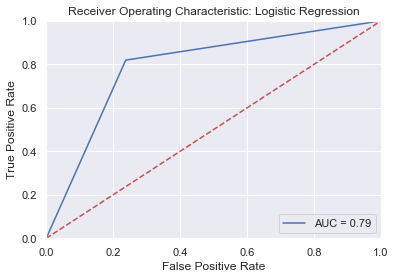

In [5]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(ytest, ypred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic: Logistic Regression')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

I'm not sure what to do with t-SNE

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next'].values
target = int_df.loc[:, 'allstar_next'].values

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target)
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

model = TSNE(learning_rate=100)
transformed = model.fit_transform(int_df)
xs = transformed[:, 0]
ys = transformed[:, 1]
_ = plt.scatter(xs, ys, c=target, cmap='plasma', alpha = 0.2)
_ = plt.show()